# Traffic Sign Detection


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Traffic Sign Dataset - Classification](https://www.kaggle.com/ahemateja19bec1025/traffic-sign-dataset-classification)) for this challenge.  
The dataset 58 classes and each class has around 120 images. 

## Data Import
Uncomment and adapt path. 

In [99]:
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
## Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
## Path to file - reminder
##path_to_data = '/content/drive/MyDrive/DeepLearningVisionHSLU/DLV03_Project/data/images/'
### Linux commands for data manipulation
#!kaggle datasets download -d 'ahemateja19bec1025/traffic-sign-dataset-classification'
#!mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/
#!unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/
#!rm /content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/*.zip

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes
 94% 179M/190M [00:04<00:00, 58.5MB/s]
100% 190M/190M [00:04<00:00, 48.0MB/s]


## Imports

In [217]:
# Built-in imports
import os
import pathlib
import random

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

import seaborn as sns
sns.set(color_codes=True)

import PIL.Image
import PIL
from PIL import Image
import skimage

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # Classification report


## Definitions

In [132]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, plot_size=[1,5]):
    fig, axes = plt.subplots(plot_size[0], plot_size[1], figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

# Get size of images
def get_size_imgs():
  # Initialized two empty lists
  widths = np.array([])
  heights = np.array([])

  for n, img in enumerate(list(data_dir.glob('*/*.png'))):
      im = Image.open(img)
      np.append(widths,im.size[0])
      np.append(heights,im.size[1])

  return widths,heights



## Data Cleaning and Pre-Processing


### Labels Preparation

In [301]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data
path_to_data = path_project_dir / 'data' / 'traffic_Data'
# Get labels
labels = pd.read_csv(
    '/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/data/labels.csv',
    delimiter=",",
    dtype = str
    )

# Check set
print('Labels info:\n')
print(labels.info(),'\n')
print('='*20)
# Check for missing values (no labels)
print('Labels contain "Unkown":\n', labels[labels.Name.str.contains("Unknown")].count(),'\n')
print('='*20)
# Check for missing values
print('Labels Name unique count:\n', labels.Name.count(),'\n')
print('='*20)

Labels info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  58 non-null     object
 1   Name     58 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB
None 

Labels contain "Unkown":
 ClassId    8
Name       8
dtype: int64 

Labels Name unique count:
 58 



In [258]:
labels

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


Eight labels are unaccounted for, let's now check which those are. 

In [74]:
unknown_labels = labels[labels.Name.str.contains("Unknown")]
unknown_labels

,ClassId,Name
40,40,Unknown1
41,41,Unknown2
42,42,Unknown3
45,45,Unknown4
49,49,Unknown5
52,52,Unknown6
56,56,Unknown7
57,57,Unknown8


Let's now open for each class a image and manual add the label.

In [244]:
# Convert ids to list
ids_missing_values = labels[labels.Name.str.contains("Unknown")].ClassId.to_list()
# Generate paths 
path_to_missing = [path_to_data.joinpath('DATA',str(id)) for id in ids_missing_values]

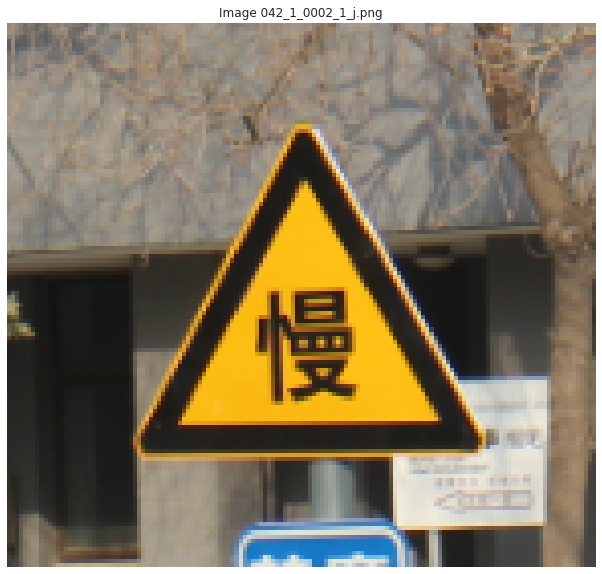

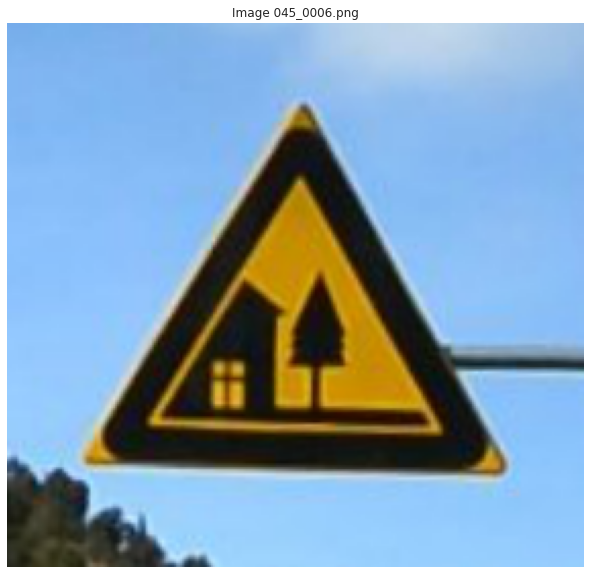

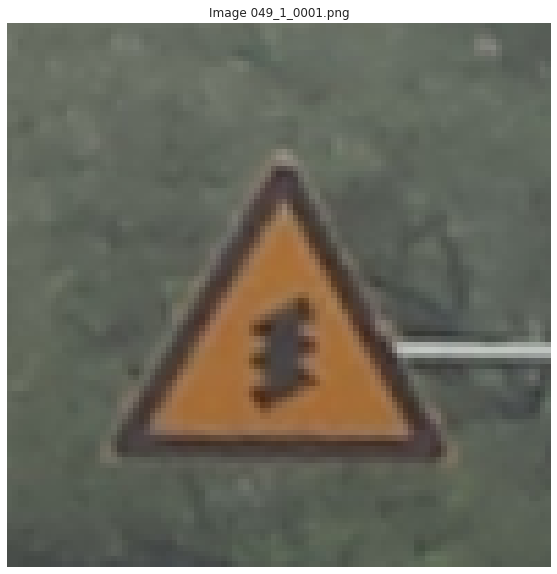

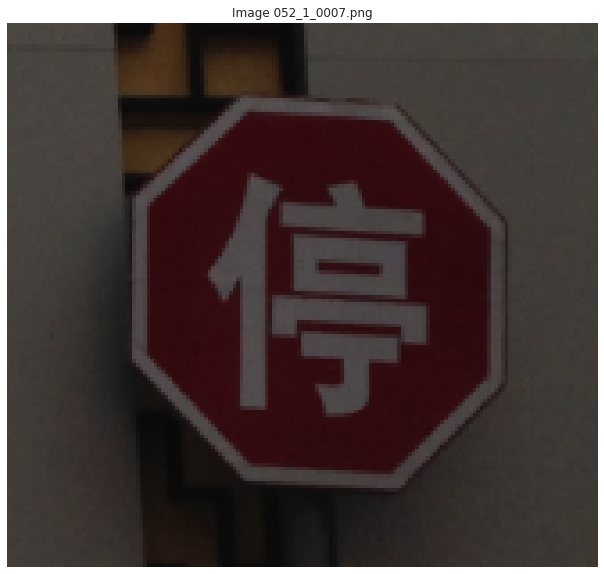

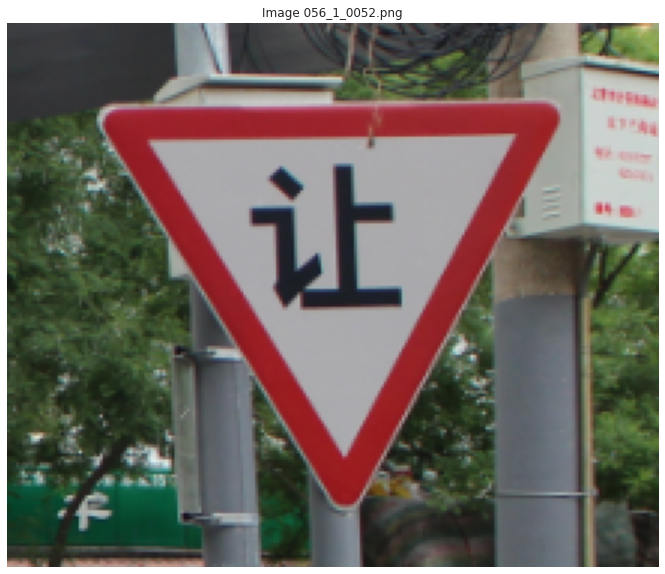

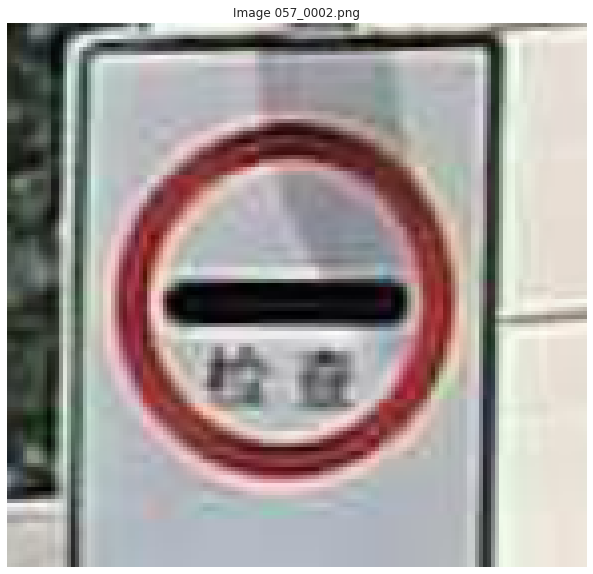

In [245]:
for directory in path_to_missing:
  np_dir_content = np.array(get_dir_content(directory))
  i = random.randint(a = 0, b = np_dir_content.shape[0])
  show_image(
      plt.imread(
          os.path.join(directory, np_dir_content[i])
          ),
      title = f'Image {np_dir_content[i]}',
      )

Categories, 42, 45, 49, 52, 56, 57 seems to be especiall Asian categories and therefore not considered.  
Category 40 & 41 are "steep down" and "steep up". 

In [246]:
#labels[labels.ClassId == 40].index.values
labels.at[40,'Name'] = 'Steep down'
labels.at[41,'Name'] = 'Steep up'

### Data Exploration


In [247]:
# Set variable for train path
data_dir = pathlib.Path(path_to_data.joinpath('DATA'))
# Check the number of images for training
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


4170


The data set contains 4170 images. 

In [303]:
# Subdirectories count
dirs = list(data_dir.glob('*/'))

lengths = {}
for dir in dirs:
  lengths[str(dir).split('/')[-1]] = len(list(dir.glob('*.png')))


lengths = (pd.DataFrame.from_dict(
    {k:[v] for k,v in lengths.items()}
    )
  .T
  .reset_index()
  .rename(columns={'index':'ClassId',0:'Count'})
  .merge(labels, how = 'left', on = 'ClassId')
  )

,ClassId,Count,Name
0,0,118,Speed limit (5km/h)
1,1,40,Speed limit (15km/h)
2,10,70,Dont Go straight
3,11,138,Dont Go Left
4,12,96,Dont Go Left or Right


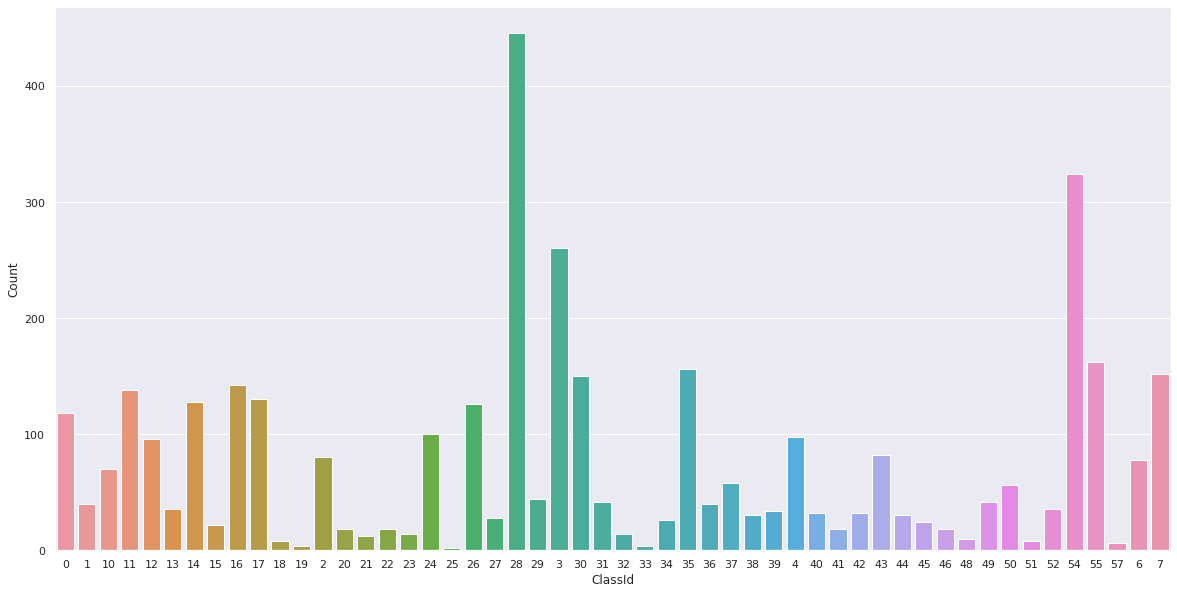

In [305]:
# Create Overview plot
sns.barplot(
    x = "ClassId",
    y = "Count",
    data = lengths.drop([42, 45, 49, 52, 56, 57])
    )
plt.show()

But within the classes the number of images is not so well distributed. Therefore we need to augmentate the images to a better count. 

### Augmentation


### Definition: Training & Validation sets

In [ ]:
img_height = 28 
img_width = 28
batch_size = round(img_count / 2,0)

# Create training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = 'inferred',
  label_mode = 'int',
  class_names = labels.Name,
  color_mode = 'rgb',
  validation_split = 0.1,
  subset="training",
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

# Create validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = 'inferred',
  label_mode = 'int',
  class_names = labels.Name,
  color_mode = 'rgb',
  validation_split = 0.1,
  subset="validation",
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

In [ ]:
# 
speed_5 = list(data_dir.glob('0/*'))
PIL.Image.open(str(speed_5[0]))

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Zero-Centering Images

## Data Augmentation

## Evaluation and Post-Processing

# Final Words 